In [1]:
!pip install wandb --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [2]:
import os
import time
import copy
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import cv2
from PIL import Image
import torch.nn.functional as F
from os.path import join as pjoin
import logging
import math
from torch.cuda.amp import GradScaler, autocast
from typing import Type, Any, Callable, Union, List, Optional
import wandb

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage

### Dataset and DataLoader

In [3]:
# Download the saliency map data
!gdown --id 1PnO7szbdub1559LfjYHMy65EDC4VhJC8

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PnO7szbdub1559LfjYHMy65EDC4VhJC8
To: /content/maps.zip
100% 452M/452M [00:05<00:00, 76.3MB/s]


In [4]:
#Unzip the data 
!mkdir '/content/map'
!unzip -qo '/content/maps.zip' -d  '/content/map'

In [5]:
# Download the images
!gdown --id 1g8j-hTT-51IG1UFwP0xTGhLdgIUCW5e5

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1g8j-hTT-51IG1UFwP0xTGhLdgIUCW5e5
To: /content/images.zip
100% 2.27G/2.27G [00:15<00:00, 147MB/s] 


In [6]:
#Unzip the images
!mkdir '/content/images'
!unzip -qo '/content/images.zip' -d  '/content/images'

In [3]:
# Mount the notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This is required for the dataset class to reduce the size of the images 

In [4]:
# Data preprocess

def preprocess_img(img_dir, channels=3):

    if channels == 1:
        img = cv2.imread(img_dir, 0)
    elif channels == 3:
        img = cv2.imread(img_dir)

    shape_r = 288
    shape_c = 384
    img_padded = np.ones((shape_r, shape_c, channels), dtype=np.uint8)
    if channels == 1:
        img_padded = np.zeros((shape_r, shape_c), dtype=np.uint8)
    original_shape = img.shape
    rows_rate = original_shape[0] / shape_r
    cols_rate = original_shape[1] / shape_c
    if rows_rate > cols_rate:
        new_cols = (original_shape[1] * shape_r) // original_shape[0]
        img = cv2.resize(img, (new_cols, shape_r))
        if new_cols > shape_c:
            new_cols = shape_c
        img_padded[:,
        ((img_padded.shape[1] - new_cols) // 2):((img_padded.shape[1] - new_cols) // 2 + new_cols)] = img
    else:
        new_rows = (original_shape[0] * shape_c) // original_shape[1]
        img = cv2.resize(img, (shape_c, new_rows))

        if new_rows > shape_r:
            new_rows = shape_r
        img_padded[((img_padded.shape[0] - new_rows) // 2):((img_padded.shape[0] - new_rows) // 2 + new_rows),
        :] = img

    return img_padded

def postprocess_img(pred, org_dir):
    pred = np.array(pred)
    org = cv2.imread(org_dir, 0)
    shape_r = org.shape[0]
    shape_c = org.shape[1]
    predictions_shape = pred.shape

    rows_rate = shape_r / predictions_shape[0]
    cols_rate = shape_c / predictions_shape[1]

    if rows_rate > cols_rate:
        new_cols = (predictions_shape[1] * shape_r) // predictions_shape[0]
        pred = cv2.resize(pred, (new_cols, shape_r))
        img = pred[:, ((pred.shape[1] - shape_c) // 2):((pred.shape[1] - shape_c) // 2 + shape_c)]
    else:
        new_rows = (predictions_shape[0] * shape_c) // predictions_shape[1]
        pred = cv2.resize(pred, (shape_c, new_rows))
        img = pred[((pred.shape[0] - shape_r) // 2):((pred.shape[0] - shape_r) // 2 + shape_r), :]

    return img

class MyDataset(Dataset):
    """Load dataset."""

    def __init__(self, ids, stimuli_dir, saliency_dir, fixation_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ids = ids
        self.stimuli_dir = stimuli_dir
        self.saliency_dir = saliency_dir
        self.fixation_dir = fixation_dir
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        im_path = self.stimuli_dir + self.ids.iloc[idx, 0]
        image = Image.open(im_path).convert('RGB')
        img = np.array(image) / 255.
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img)
        if self.transform:
           img = self.transform(image)

        smap_path = self.saliency_dir + self.ids.iloc[idx, 1]
        saliency = Image.open(smap_path)

        smap = np.expand_dims(np.array(saliency) / 255., axis=0)
        smap = torch.from_numpy(smap)

        fmap_path = self.fixation_dir + self.ids.iloc[idx, 2]
        fixation = Image.open(fmap_path)

        fmap = np.expand_dims(np.array(fixation) / 255., axis=0)
        fmap = torch.from_numpy(fmap)

        sample = {'image': img, 'saliency': smap, 'fixation': fmap}

        return sample

#### Dataset class to process the images 

In [8]:
class MyDataset(Dataset):
    """Load dataset."""

    def __init__(self,stimuli_dir, saliency_dir,transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # self.ids = ids
        self.image_dir = stimuli_dir
        self.annotation_dir = saliency_dir
        # self.fixation_dir = fixation_dir
        self.transform = transform

        # This line of code returns a sorted list of full paths to each image in the directory
        self.img_paths = list(map(lambda fname: os.path.join(self.image_dir, fname), sorted(os.listdir(self.image_dir))))

        # Annotated images
        self.annotation_paths = list(map(lambda fname: os.path.join(self.annotation_dir, fname), sorted(os.listdir(self.annotation_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):

        image   = preprocess_img(self.img_paths[idx])

        # image   = Image.open(self.img_paths[idx]).convert('RGB')

        img = np.array(image) / 255.
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img)

        if self.transform:
           img = self.transform(image)



        # smap_path = self.saliency_dir + self.ids.iloc[idx, 1]
        # saliency = Image.open(self.annotation_paths[idx])
        saliency   = preprocess_img(self.annotation_paths[idx], channels=1)


        smap = np.expand_dims(np.array(saliency) / 255., axis=0)
        smap = torch.from_numpy(smap)

        sample = {'image': img, 'saliency': smap}

        return sample

MIT1003 DATASET

In [9]:
!mkdir '/content/data'
!unzip -qo '/content/drive/MyDrive/Colab Notebooks/Datasets/MIT1003.zip' -d  '/content/data'

In [5]:
# Create directories for the train and validation images and annotations
DATA_DIR = '/content/data/MIT1003'
MIT1003_TEST_IMAGE_DIR = os.path.join(DATA_DIR,"images")
MIT1003_TEST_ANNOT_DIR = os.path.join(DATA_DIR, "annotations")

In [6]:
# Transforms for the train images and annotations
mit1003_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

mit1003_annot_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224))
])

In [12]:
class MIT1003Dataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None, annot_transforms =None, train=True):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transforms
        self.annot_transforms = annot_transforms
        self.train = train

        # This line of code returns a sorted list of full paths to each image in the directory
        self.img_paths = list(map(lambda fname: os.path.join(self.image_dir, fname), sorted(os.listdir(self.image_dir))))

        # Annotated images
        self.annotation_paths = list(map(lambda fname: os.path.join(self.annotation_dir, fname) if not "Pts" in fname else "null", sorted(os.listdir(self.annotation_dir))))
        self.annotation_paths = [p for p in self.annotation_paths if p != "null"]

        assert len(self.annotation_paths) == len(self.img_paths)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image   = preprocess_img(self.img_paths[idx])

        img = np.array(image) / 255.
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img)

        if self.transform:
           img = self.transform(image)



        # smap_path = self.saliency_dir + self.ids.iloc[idx, 1]
        # saliency = Image.open(self.annotation_paths[idx])
        saliency   = preprocess_img(self.annotation_paths[idx], channels=1)


        smap = np.expand_dims(np.array(saliency) / 255., axis=0)
        smap = torch.from_numpy(smap)

        sample = {'image': img, 'saliency': smap}

        return sample

#### Create the train and validation data

In [9]:
train_set = MyDataset(stimuli_dir= '/content/images/images/train', 
                      saliency_dir= '/content/map/train',
                      transform=transforms.Compose([
                      # transforms.Resize((384, 288)),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      ]))

val_set = MyDataset(stimuli_dir= '/content/images/images/val', 
                      saliency_dir= '/content/map/val',
                      transform=transforms.Compose([
                      # transforms.Resize((384, 288)),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]))

In [13]:
mit1003_test_dataset = MIT1003Dataset(MIT1003_TEST_IMAGE_DIR,MIT1003_TEST_ANNOT_DIR)
mit1003_test_loader = DataLoader(mit1003_test_dataset, batch_size=32, drop_last =False, num_workers =2)

Config

In [10]:
config = {
    'batch_size': 4, # Increase this if your GPU can handle it
    'lr': 1e-5,
    'epochs': 10, # 10 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

Dataloaders

In [11]:
dataloaders = {'train':DataLoader(train_set, batch_size=config['batch_size'],shuffle=True, num_workers=4),
               'val':DataLoader(val_set, batch_size=config['batch_size'],shuffle=False, num_workers=4)}

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Sanity check for the dataloaders

In [12]:
for data in dataloaders['val']:
    print(data['saliency'].shape)
    # print(data['saliency'].shape)
    break

torch.Size([4, 1, 288, 384])


View some of the images from the dataloader

torch.Size([32, 3, 288, 384])
torch.Size([32, 1, 288, 384])


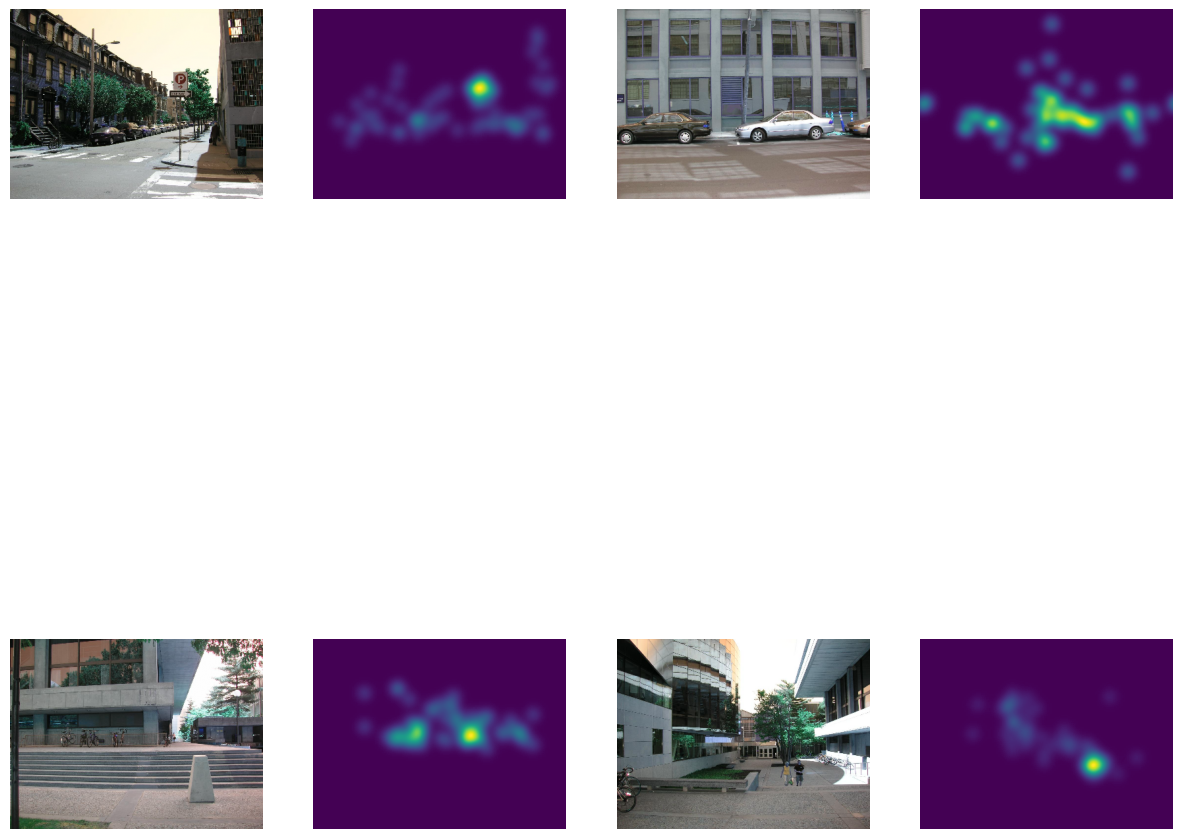

In [19]:
# Display some of the images in the mit1003 dataset together with their annotations
r, c = [2,4]
fig, ax = plt.subplots(r, c, figsize = (15, 15)) 

k = 0

for data in mit1003_test_loader:
    # print(data)
    x, y = data['image'], data['saliency']

    print(x.shape)
    print(y.shape)

    # print(x.shape)

    for i in range(r):
        for j in range(0, c, 2):
            img = x[k].numpy().transpose(1,2,0)
            ann = y[k].numpy().transpose(1,2,0)
            ax[i, j].imshow(img)
            ax[i, j].axis("off")
            ax[i, j+1].imshow(ann)
            ax[i, j+1].axis("off")
            k +=1
    break        

torch.Size([4, 3, 288, 384])
torch.Size([4, 1, 288, 384])


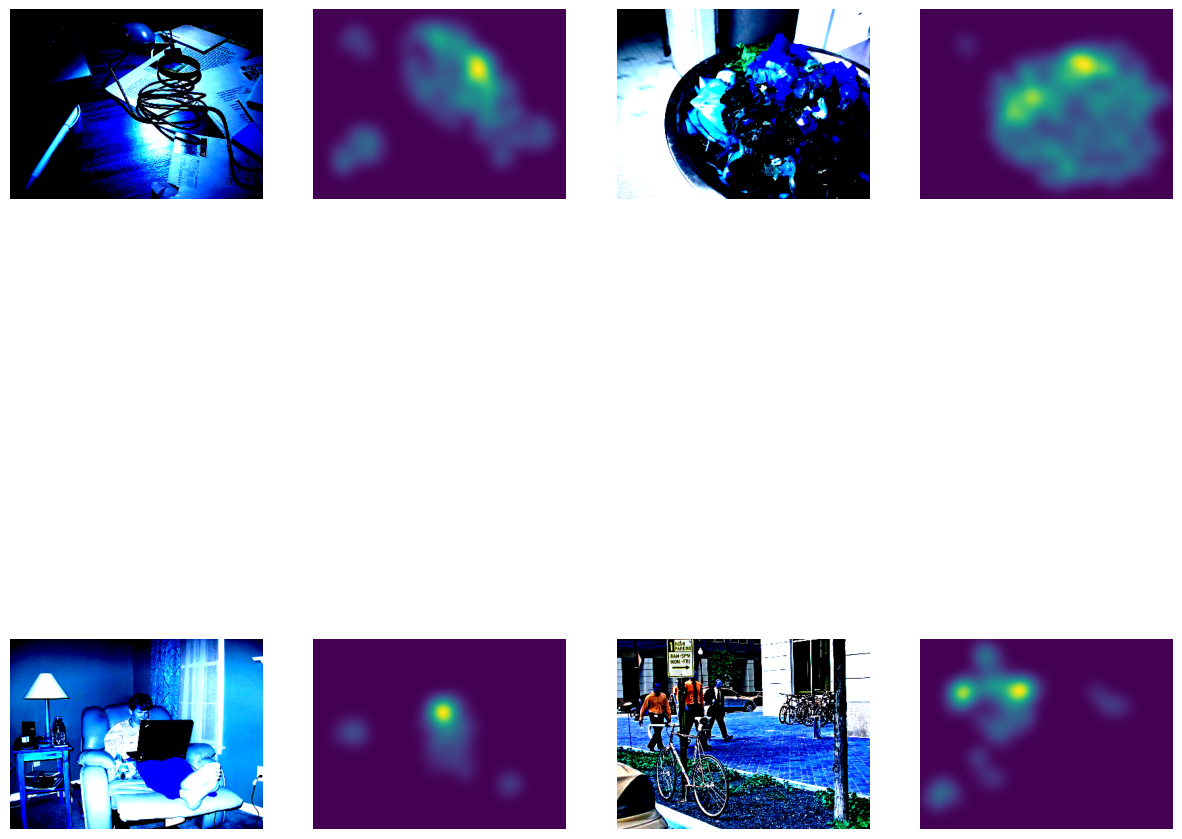

In [13]:
# Display some of the images in the dataset together with their annotations
r, c = [2,4]
fig, ax = plt.subplots(r, c, figsize = (15, 15)) 

k = 0

for data in dataloaders['train']:
    x, y = data['image'], data['saliency']

    print(x.shape)
    print(y.shape)

    for i in range(r):
        for j in range(0, c, 2):
            img = x[k].numpy().transpose(1,2,0)
            ann = y[k].numpy().transpose(1,2,0)
            # gauss = z[k].numpy().transpose(1,2,0)
            ax[i, j].imshow(img)
            ax[i, j].axis("off")
            ax[i, j+1].imshow(ann)
            ax[i, j+1].axis("off")
            # ax[i, j+2].imshow(gauss)
            # ax[i, j+2].axis("off")
            k +=1
    break

#### Utils for the loss 

In [14]:
class SaliencyLoss(nn.Module):
    def __init__(self):
        super(SaliencyLoss, self).__init__()

    def forward(self, preds, labels, loss_type='cc'):
        losses = []
        if loss_type == 'cc':
            for i in range(labels.shape[0]): # labels.shape[0] is batch size
                loss = loss_CC(preds[i],labels[i])
                losses.append(loss)

        elif loss_type == 'kldiv':
            for i in range(labels.shape[0]):
                loss = loss_KLdiv(preds[i],labels[i])
                losses.append(loss)

        elif loss_type == 'sim':
            for i in range(labels.shape[0]):
                loss = loss_similarity(preds[i],labels[i])
                losses.append(loss)

        elif loss_type == 'nss':
            for i in range(labels.shape[0]):
                loss = loss_NSS(preds[i],labels[i])
                losses.append(loss)
            
        return torch.stack(losses).mean(dim=0, keepdim=True)
        
        
def loss_KLdiv(pred_map, gt_map):
    eps = 2.2204e-16
    pred_map = pred_map/torch.sum(pred_map)
    gt_map = gt_map/torch.sum(gt_map)
    div = torch.sum(torch.mul(gt_map, torch.log(eps + torch.div(gt_map,pred_map+eps))))
    return div 
        
    
def loss_CC(pred_map,gt_map):
    gt_map_ = (gt_map - torch.mean(gt_map))
    pred_map_ = (pred_map - torch.mean(pred_map))
    cc = torch.sum(torch.mul(gt_map_,pred_map_))/torch.sqrt(torch.sum(torch.mul(gt_map_,gt_map_))*torch.sum(torch.mul(pred_map_,pred_map_)))
    return cc


def loss_similarity(pred_map,gt_map):
    gt_map = (gt_map - torch.min(gt_map))/(torch.max(gt_map)-torch.min(gt_map))
    gt_map = gt_map/torch.sum(gt_map)
    
    pred_map = (pred_map - torch.min(pred_map))/(torch.max(pred_map)-torch.min(pred_map))
    pred_map = pred_map/torch.sum(pred_map)
    
    diff = torch.min(gt_map,pred_map)
    score = torch.sum(diff)
    
    return score
    
    
def loss_NSS(pred_map,fix_map):
    '''ground truth here is fixation map'''

    pred_map_ = (pred_map - torch.mean(pred_map))/torch.std(pred_map)
    mask = fix_map.gt(0)
    score = torch.mean(torch.masked_select(pred_map_, mask))
    return score

### Model

### Attention module

In [15]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu}

class Attention(nn.Module):
    def __init__(self, config):
        super(Attention, self).__init__()
        self.num_attention_heads = config["num_heads"]  # 12
        self.attention_head_size = int(config['hidden_size'] / self.num_attention_heads)    # 42
        self.all_head_size = self.num_attention_heads * self.attention_head_size    # 12*42=504

        self.query = Linear(config['hidden_size'], self.all_head_size)  # (512, 504)
        self.key = Linear(config['hidden_size'], self.all_head_size)
        self.value = Linear(config['hidden_size'], self.all_head_size)

        # self.out = Linear(config['hidden_size'], config['hidden_size'])
        self.out = Linear(self.all_head_size, config['hidden_size'])
        self.attn_dropout = Dropout(config["attention_dropout_rate"])
        self.proj_dropout = Dropout(config["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):

        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output


class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config['hidden_size'], config["mlp_dim"])
        self.fc2 = Linear(config["mlp_dim"], config['hidden_size'])
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config["dropout_rate"])
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super(Block, self).__init__()
        self.flag = config['num_heads']
        self.hidden_size = config['hidden_size']
        self.ffn_norm = LayerNorm(config['hidden_size'], eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config)
        self.attention_norm = LayerNorm(config['hidden_size'], eps=1e-6)

    def forward(self, x):
        h = x

        x = self.attention_norm(x)
        x = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x


class Encoder(nn.Module):
    def __init__(self, config):
        super(Encoder, self).__init__()

        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config['hidden_size'], eps=1e-6)
        for _ in range(config["num_layers"]):
            layer = Block(config)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        for layer_block in self.layer:
            hidden_states = layer_block(hidden_states)
        encoded = self.encoder_norm(hidden_states)

        return encoded

Download the model

In [16]:
efficient_model = torch.hub.load("pytorch/vision", "convnext_large", weights="IMAGENET1K_V1")

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:11<00:00, 67.7MB/s]


#### Create the model

In [17]:
cfg1 = {
"hidden_size" : 768,
"mlp_dim" : 768*4,
"num_heads" : 12,
"num_layers" : 2,
"attention_dropout_rate" : 0,
"dropout_rate" : 0.0,
}

cfg2 = {
"hidden_size" : 768,
"mlp_dim" : 768*4,
"num_heads" : 12,
"num_layers" : 2,
"attention_dropout_rate" : 0,
"dropout_rate" : 0.0,
}

cfg3 = {
"hidden_size" : 512,
"mlp_dim" : 512*4,
"num_heads" : 8,
"num_layers" : 2,
"attention_dropout_rate" : 0,
"dropout_rate" : 0.0,
}


class TranSalNet(nn.Module):

    def __init__(self):
        super(TranSalNet, self).__init__()
        self.encoder = _Encoder()
        self.decoder = _Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class _Encoder(nn.Module):
    def __init__(self):
        super(_Encoder, self).__init__()
        base_model = efficient_model #densenet201(pretrained=False)#161
        base_layers = list(base_model.children())[0][:-1]
        self.encoder = nn.ModuleList(base_layers).eval()

    def forward(self, x):
        outputs = []
        for ii,layer in enumerate(self.encoder):
            x = layer(x)
            if ii in {3, 5, 6}: #3	5	7
                outputs.append(x)
        return outputs

class _Decoder(nn.Module):

    def __init__(self):
        super(_Decoder, self).__init__()
        self.conv1 = nn.Conv2d(768, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(768, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv5 = nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv6 = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv7 = nn.Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.batchnorm1 = nn.BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm2 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm4 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm5 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm6 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        #changed these to match the configs of efficientnet_v2_l
        self.TransEncoder1 = TransEncoder(in_channels=1536, spatial_size=9*12, cfg=cfg1)#<-2208
        self.TransEncoder2 = TransEncoder(in_channels=768, spatial_size=18*24, cfg=cfg2)#<-2112
        self.TransEncoder3 = TransEncoder(in_channels=384, spatial_size=36*48, cfg=cfg3)#<-768

        self.add = torch.add
        self.relu = nn.ReLU(True)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x3, x4, x5 = x

        x5 = self.TransEncoder1(x5)
        x5 = self.conv1(x5)
        x5 = self.batchnorm1(x5)
        x5 = self.relu(x5)
        x5 = self.upsample(x5)

        x4_a = self.TransEncoder2(x4)
        x4 = x5 * x4_a
        x4 = self.relu(x4)
        x4 = self.conv2(x4)
        x4 = self.batchnorm2(x4)
        x4 = self.relu(x4)
        x4 = self.upsample(x4)

        x3_a = self.TransEncoder3(x3)
        x3 = x4 * x3_a
        x3 = self.relu(x3)
        x3 = self.conv3(x3)
        x3 = self.batchnorm3(x3)
        x3 = self.relu(x3)
        x3 = self.upsample(x3)

        x2 = self.conv4(x3)
        x2 = self.batchnorm4(x2)
        x2 = self.relu(x2)
        x2 = self.upsample(x2)
        x2 = self.conv5(x2)
        x2 = self.batchnorm5(x2)
        x2 = self.relu(x2)

        x1 = self.upsample(x2)
        x1 = self.conv6(x1)
        x1 = self.batchnorm6(x1)
        x1 = self.relu(x1)
        x1 = self.conv7(x1)
        x = self.sigmoid(x1)

        return x


class TransEncoder(nn.Module):

    def __init__(self, in_channels, spatial_size, cfg):
        super(TransEncoder, self).__init__()

        self.patch_embeddings = nn.Conv2d(in_channels=in_channels,
                                          out_channels=cfg['hidden_size'],
                                          kernel_size=1,
                                          stride=1)
        self.position_embeddings = nn.Parameter(torch.zeros(1, spatial_size, cfg['hidden_size']))

        self.transformer_encoder = Encoder(cfg)

    def forward(self, x):
        a, b = x.shape[2], x.shape[3]
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)

        embeddings = x + self.position_embeddings
        x = self.transformer_encoder(embeddings)
        B, n_patch, hidden = x.shape
        x = x.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, a, b)

        return x

Create the model 

In [18]:
transalnet_efficientnet = TranSalNet()

In [15]:
#Creata a dummy image
myimage  = torch.randn(1,3,384, 288)

In [19]:
# Forward pass
z = transalnet_efficientnet(x)
z.shape

torch.Size([4, 1, 288, 384])

### Train and test functions

In [26]:
def train(model, optimizer, criterion):
    model.train()
    model.to(device)
    epoch_loss = 0
    scaler = GradScaler()
    train_losses = []

    # batch_bar   = tqdm(total=len(dataloaders['train']), dynamic_ncols=True, leave=False, position=0, desc='Train')

    with tqdm(total=len(dataloaders['train']), dynamic_ncols=True, leave=True, position=0, desc='Train') as batch_bar:
      for i_batch, sample_batched in tqdm(enumerate(dataloaders['train'])):
          # Initialize Gradients
          optimizer.zero_grad()

          stimuli, smap = sample_batched['image'].to(device), sample_batched['saliency'].to(device)

          with autocast(dtype= torch.float16):
              outputs = model(stimuli)

              loss = criterion(outputs, smap)

          scaler.scale(loss).backward()

          scaler.step(optimizer)

          # Updates the scale for next iteration.
          scaler.update()

          loss = loss.item()
          epoch_loss += loss

          batch_bar.set_postfix(loss="{:.04f}".format(float(epoch_loss / (i_batch + 1))), lr="{:.04f}".format(optimizer.param_groups[0]['lr']))
          batch_bar.update()
    
    
    batch_bar.close()

    epoch_loss /= epoch_loss / (len(dataloaders['train']))
    # self.epochs += 1
    # print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f'
    #               % (self.epochs, self.max_epochs, epoch_loss, self.optimizer.param_groups[0]['lr']))
    train_losses.append(epoch_loss)

    return epoch_loss

In [27]:
### Store the validation losses
validation_losses = SaliencyLoss()
kl_div_list = list()
sim_list    = list()
cc_list     = list()

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [23]:
def eval(model, dataloader):
    model.eval()
    epoch_loss = 0
    vloss1, vloss2, vloss3 = 0, 0, 0
    # batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=True, position=0, desc='Validation')
    # batch_bar     = tqdm(dataloader)

    with tqdm(total=len(dataloader), dynamic_ncols=True, leave=True, position=0, desc='Validation') as batch_bar:
      for i_batch, sample_batched in tqdm(enumerate(dataloader)):
          stimuli, smap = sample_batched['image'].to(device), sample_batched['saliency'].to(device)

          with torch.no_grad():
              outputs = model(stimuli)

              loss1 = validation_losses(outputs, smap, 'cc')
              loss2 = validation_losses(outputs, smap, 'kldiv')
              loss3 = validation_losses(outputs, smap, 'sim')

          vloss1  += loss1
          vloss2  += loss2
          vloss3  += loss3

          batch_bar.set_postfix(cc="{:.04f}".format(float(vloss1 / (i_batch + 1))), 
                                kldiv="{:.04f}".format(float(vloss2 / (i_batch + 1))),
                                sim="{:.04f}".format(float(vloss3 / (i_batch + 1))))
          batch_bar.update()

    batch_bar.close()

    vloss1   /= len(dataloader)
    vloss2    /= len(dataloader)
    vloss3    /= len(dataloader)

    kl_div_list.append(vloss2)
    sim_list.append(vloss3)
    cc_list.append(vloss1)

    return vloss1, vloss2, vloss3

Optimizer loss and scheduler

In [28]:
optimizer = optim.Adam(transalnet_efficientnet.parameters(),lr=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
criterion   = torch.nn.BCEWithLogitsLoss()
num_epochs = 10

Wandb

In [ ]:
wandb.login(key="")#Fill in the wandb key

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "transalnet_efficientnet", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "visual_saliency", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

### Experiments

In [29]:
best_vloss = 0.0

for epoch in range(config['epochs']):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss = train(transalnet_efficientnet, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_loss,
        curr_lr))
    

    if (epoch+1)%5 ==0:
        vloss1, vloss2, vloss3 = eval(transalnet_efficientnet, dataloaders['val'])

        # print("\nEpoch {}/{}: \n cc Loss {:.04f}\t  sim Loss {:.04f} \t kld Loss {:.04f}\t Learning Rate {:.04f}".format(
        # epoch + 1,
        # config['epochs'],
        # vloss1,
        # vloss3,
        # vloss2,
        # curr_lr))

        # wandb.log({"train_loss":train_loss, 'cc loss': vloss1, 'sim loss':vloss3, 
        #        'kld loss': vloss2, "learning_Rate": curr_lr})

    scheduler.step()
        
# run.finish()


Epoch: 1/10


Train:   0%|          | 0/2500 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

Train: 100%|██████████| 2500/2500 [16:39<00:00,  2.50it/s, loss=0.7597, lr=0.0000]
2500it [16:39,  2.50it/s]
Train: 100%|██████████| 2500/2500 [16:40<00:00,  2.50it/s, loss=0.7597, lr=0.0000]



Epoch 1/10: 
Train Loss 2500.0000	 Learning Rate 0.0000

Epoch: 2/10


Train: 100%|██████████| 2500/2500 [16:46<00:00,  2.52it/s, loss=0.7032, lr=0.0000]
2500it [16:46,  2.48it/s]
Train: 100%|██████████| 2500/2500 [16:47<00:00,  2.48it/s, loss=0.7032, lr=0.0000]



Epoch 2/10: 
Train Loss 2500.0000	 Learning Rate 0.0000

Epoch: 3/10


Train: 100%|██████████| 2500/2500 [16:49<00:00,  2.53it/s, loss=0.6944, lr=0.0000]
2500it [16:48,  2.48it/s]
Train: 100%|██████████| 2500/2500 [16:49<00:00,  2.48it/s, loss=0.6944, lr=0.0000]



Epoch 3/10: 
Train Loss 2500.0000	 Learning Rate 0.0000

Epoch: 4/10


Train: 100%|██████████| 2500/2500 [16:49<00:00,  2.51it/s, loss=0.6925, lr=0.0000]
2500it [16:48,  2.48it/s]
Train: 100%|██████████| 2500/2500 [16:49<00:00,  2.48it/s, loss=0.6925, lr=0.0000]



Epoch 4/10: 
Train Loss 2500.0000	 Learning Rate 0.0000

Epoch: 5/10


Train: 100%|██████████| 2500/2500 [16:56<00:00,  2.54it/s, loss=0.6922, lr=0.0000]
2500it [16:56,  2.46it/s]
Train: 100%|██████████| 2500/2500 [16:56<00:00,  2.46it/s, loss=0.6922, lr=0.0000]



Epoch 5/10: 
Train Loss 2500.0000	 Learning Rate 0.0000


Validation: 100%|██████████| 1250/1250 [07:15<00:00,  2.92it/s, cc=0.5776, kldiv=1.5859, sim=0.3065]
1250it [07:15,  2.87it/s]
Validation: 100%|██████████| 1250/1250 [07:16<00:00,  2.86it/s, cc=0.5776, kldiv=1.5859, sim=0.3065]



Epoch: 6/10


Train: 100%|██████████| 2500/2500 [16:59<00:00,  2.51it/s, loss=0.6918, lr=0.0000]
2500it [16:59,  2.45it/s]
Train: 100%|██████████| 2500/2500 [16:59<00:00,  2.45it/s, loss=0.6918, lr=0.0000]



Epoch 6/10: 
Train Loss 2500.0000	 Learning Rate 0.0000

Epoch: 7/10


Train: 100%|██████████| 2500/2500 [17:01<00:00,  2.46it/s, loss=0.6917, lr=0.0000]
2500it [17:01,  2.45it/s]
Train: 100%|██████████| 2500/2500 [17:01<00:00,  2.45it/s, loss=0.6917, lr=0.0000]



Epoch 7/10: 
Train Loss 2500.0000	 Learning Rate 0.0000

Epoch: 8/10


Train: 100%|██████████| 2500/2500 [17:03<00:00,  2.50it/s, loss=0.6916, lr=0.0000]
2500it [17:02,  2.44it/s]
Train: 100%|██████████| 2500/2500 [17:03<00:00,  2.44it/s, loss=0.6916, lr=0.0000]



Epoch 8/10: 
Train Loss 2500.0000	 Learning Rate 0.0000

Epoch: 9/10


Train: 100%|██████████| 2500/2500 [16:57<00:00,  2.55it/s, loss=0.6916, lr=0.0000]
2500it [16:57,  2.46it/s]
Train: 100%|██████████| 2500/2500 [16:58<00:00,  2.46it/s, loss=0.6916, lr=0.0000]



Epoch 9/10: 
Train Loss 2500.0000	 Learning Rate 0.0000

Epoch: 10/10


Train: 100%|██████████| 2500/2500 [17:00<00:00,  2.48it/s, loss=0.6916, lr=0.0000]
2500it [17:00,  2.45it/s]
Train: 100%|██████████| 2500/2500 [17:00<00:00,  2.45it/s, loss=0.6916, lr=0.0000]



Epoch 10/10: 
Train Loss 2500.0000	 Learning Rate 0.0000


Validation: 100%|██████████| 1250/1250 [07:17<00:00,  2.94it/s, cc=0.5606, kldiv=1.8485, sim=0.2766]
1250it [07:16,  2.86it/s]
Validation: 100%|██████████| 1250/1250 [07:17<00:00,  2.86it/s, cc=0.5606, kldiv=1.8485, sim=0.2766]
